In [2]:
import cv2
import os
import numpy as np

import torch
from PIL import Image
from torchvision import transforms as T

from ultralytics import YOLO

In [ ]:
import matplotlib.pyplot as plt
from sort import Sort
from collections import defaultdict
from tqdm import tqdm

import yt_dlp

from roboflow import Roboflow

from IPython.display import Image, display

from filterpy.kalman import KalmanFilter

import json

In [2]:
# !pip install -U yt-dlp

In [ ]:
# Downloading Video

In [3]:

url = "https://www.youtube.com/shorts/MwxxofLNpTg"

ydl_opts = {
    'outtmpl': r'C:\Users\algba\NikiTechSolutions\CVAI-HW3\CarVideo\%(title)s.%(ext)s',
    'format': 'bestvideo+bestaudio/best',
    'merge_output_format': 'mp4',
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([url])


[youtube] Extracting URL: https://www.youtube.com/shorts/MwxxofLNpTg
[youtube] MwxxofLNpTg: Downloading webpage
[youtube] MwxxofLNpTg: Downloading tv client config
[youtube] MwxxofLNpTg: Downloading player 69f581a5
[youtube] MwxxofLNpTg: Downloading tv player API JSON
[youtube] MwxxofLNpTg: Downloading ios player API JSON
[youtube] MwxxofLNpTg: Downloading m3u8 information
[info] MwxxofLNpTg: Downloading 1 format(s): 247+251
[download] Destination: C:\Users\algba\NikiTechSolutions\CVAI-HW3\CarVideo\Active Track - Near Crash ｜ DJI Mini 4 Pro #dji #mini4 #followme #drone #activetrack #wildtrak.f247.webm
[download] 100% of    4.03MiB in 00:00:00 at 9.29MiB/s   
[download] Destination: C:\Users\algba\NikiTechSolutions\CVAI-HW3\CarVideo\Active Track - Near Crash ｜ DJI Mini 4 Pro #dji #mini4 #followme #drone #activetrack #wildtrak.f251.webm
[download] 100% of  228.36KiB in 00:00:00 at 952.28KiB/s   
[Merger] Merging formats into "C:\Users\algba\NikiTechSolutions\CVAI-HW3\CarVideo\Active Trac

In [ ]:
# Split Video into frames: car video

In [6]:
def split_video_to_frames(video_path, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_path = os.path.join(output_dir, f"frame_{frame_count:04d}.png")
        cv2.imwrite(frame_path, frame) 
        frame_count += 1

    cap.release()
    print(f"Extracted {frame_count} frames from {video_path}")

video_paths = ["C:/Users/algba/NikiTechSolutions/CVAI-HW3/CarVideo/CarVideoaA1.mp4"]

for video_path in video_paths:
    output_dir = os.path.splitext(video_path)[0] + "_frames"
    split_video_to_frames(video_path, output_dir)

Extracted 451 frames from C:/Users/algba/NikiTechSolutions/CVAI-HW3/CarVideo/CarVideoaA1.mp4


In [ ]:
# Load the model and detect cars

In [9]:
# !pip install ultralytics

In [10]:
os.environ['YOLO_HOME'] = r"C:\Users\algba\NikiTechSolutions\CVAI-HW3"

In [13]:
model = YOLO('yolov8m.pt') 

# Frame folders
frames_dir = r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\CarVideo\CarVideoaA1_frames"
output_frames_dir = frames_dir + "_labeled"
os.makedirs(output_frames_dir, exist_ok=True)

frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.png')])

# Run detection and annotate
for frame_file in frame_files:
    frame_path = os.path.join(frames_dir, frame_file)
    img = cv2.imread(frame_path)

    results = model.predict(source=img, classes=[2], conf=0.3, verbose=False)  # class 2 = car

    for r in results:
        for box in r.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
            conf = float(box.conf[0])

            # Draw box and centroid
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.circle(img, (cx, cy), 5, (0, 0, 255), -1)
            cv2.putText(img, f"Car ({conf:.2f})", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Save the labeled frame
    out_path = os.path.join(output_frames_dir, frame_file)
    cv2.imwrite(out_path, img)

100%|█████████████████████████████████████████████████████████████████████████████| 49.7M/49.7M [00:01<00:00, 32.0MB/s]


In [ ]:
# Combine labeled frames into a video

In [ ]:
# Set up paths
output_frames_dir = r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\CarVideo\CarVideoaA1_frames_labeled"
output_video_path = r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\CarVideo\CarVideoaA1_labeled.mp4"
fps = 30  

# Get sorted list of frame files
frame_files = sorted([f for f in os.listdir(output_frames_dir) if f.endswith('.png')])

# Read first frame to get dimensions
sample_frame_path = os.path.join(output_frames_dir, frame_files[0])
sample_frame = cv2.imread(sample_frame_path)
height, width, _ = sample_frame.shape

# Define video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Write frames to video
for frame_file in frame_files:
    frame_path = os.path.join(output_frames_dir, frame_file)
    frame = cv2.imread(frame_path)
    video_writer.write(frame)

video_writer.release()
print(f" Labeled video saved to: {output_video_path}")


In [ ]:
# Kalman Filter

In [ ]:
# Record centroids

In [ ]:
model = YOLO('yolov8m.pt') 


frames_dir = r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\CarVideo\CarVideoaA1_frames"
output_frames_dir = frames_dir + "_labeled"
os.makedirs(output_frames_dir, exist_ok=True)

# Get all frame files in order
frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.png')])

# Store centroids
centroids = []

# Process each frame
for frame_file in frame_files:
    frame_path = os.path.join(frames_dir, frame_file)
    img = cv2.imread(frame_path)

    results = model.predict(source=img, classes=[2], conf=0.3, verbose=False)  # class 2 = car
    found_car = False

    for r in results:
        for box in r.boxes:
            label_id = int(box.cls[0])
            if label_id == 2:  # Car
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
                centroids.append((cx, cy))
                found_car = True

                # Draw bounding box and centroid
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.circle(img, (cx, cy), 5, (0, 0, 255), -1)
                cv2.putText(img, f"Car ({float(box.conf[0]):.2f})", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    if not found_car:
        centroids.append(None)  # No detection in this frame

    # Save annotated frame
    out_path = os.path.join(output_frames_dir, frame_file)
    cv2.imwrite(out_path, img)

# Save centroids to .npy file
save_path = r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\centroids.npy"

In [ ]:
np.save(save_path, np.array(centroids, dtype=object))
print(f" Saved {len(centroids)} centroids to: {save_path}")

In [ ]:
# Kalman Filter Tracking

In [19]:
# !pip install filterpy

In [20]:
#  Load saved centroids
centroids = np.load(r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\centroids.npy", allow_pickle=True).tolist()

#  Setup 2D Kalman Filter
kf = KalmanFilter(dim_x=4, dim_z=2) 

kf.F = np.array([[1, 0, 1, 0],
                 [0, 1, 0, 1],
                 [0, 0, 1, 0],
                 [0, 0, 0, 1]]) 

kf.H = np.array([[1, 0, 0, 0],
                 [0, 1, 0, 0]])  

kf.P *= 1000.    
kf.Q *= 1e-2      
kf.R *= 10.       

#  Initialize with first detected position
initial_pos = next(pt for pt in centroids if pt is not None)
kf.x[:2] = np.array(initial_pos).reshape(2, 1)

#  Step 2: Run Kalman filter
predictions = []
innovations = []

for measurement in centroids:
    kf.predict()

    if measurement is not None:
        z = np.array(measurement)
        kf.update(z)
        innovation = z - (kf.H @ kf.x).ravel()
        innovations.append(np.linalg.norm(innovation))
    else:
        innovations.append(0.0)  

    predictions.append((kf.x[0, 0], kf.x[1, 0]))


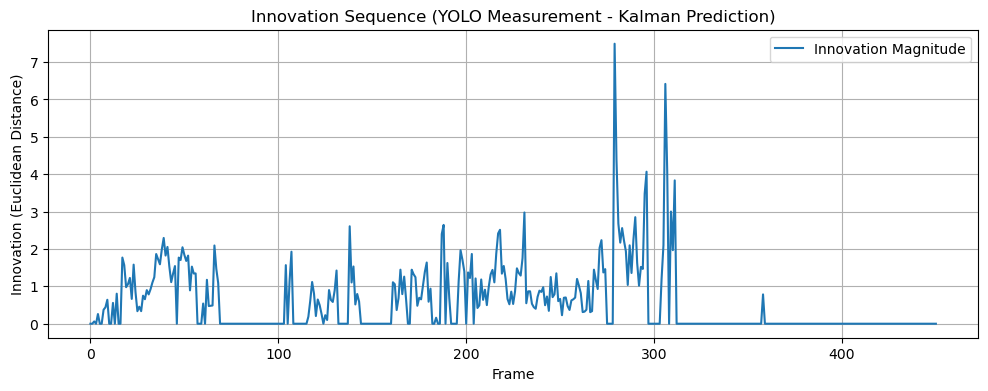

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(innovations, label="Innovation Magnitude")
plt.xlabel("Frame")
plt.ylabel("Innovation (Euclidean Distance)")
plt.title("Innovation Sequence (YOLO Measurement - Kalman Prediction)")
plt.legend()
plt.grid(True)
plt.show()

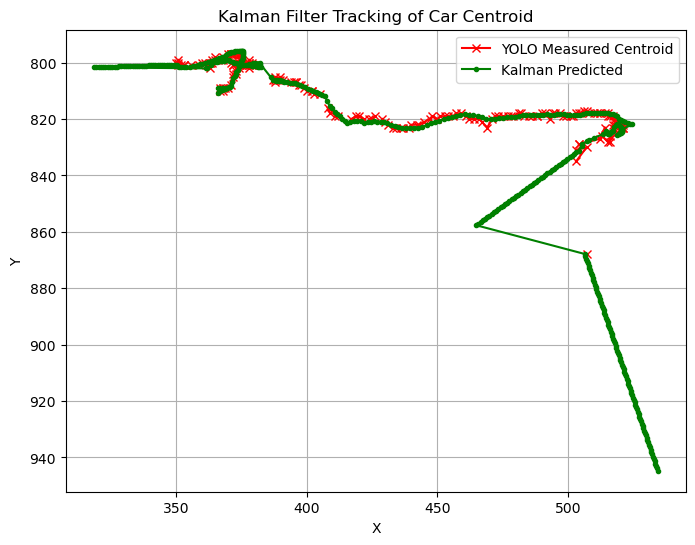

In [22]:
# predicted vs measured positions
measured = np.array([[*pt] if pt is not None else [np.nan, np.nan] for pt in centroids])
predicted = np.array(predictions)

plt.figure(figsize=(8, 6))
plt.plot(measured[:, 0], measured[:, 1], 'rx-', label='YOLO Measured Centroid')
plt.plot(predicted[:, 0], predicted[:, 1], 'g.-', label='Kalman Predicted')
plt.gca().invert_yaxis() 
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Kalman Filter Tracking of Car Centroid")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Kalman Filter Video (Centroid)

In [23]:
# Input: frame folder and Kalman predictions
frames_dir = r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\CarVideo\CarVideoaA1_frames"
output_kf_video = r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\CarVideo\CarVideoaA1_kalman.mp4"
frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.png')])

# Get frame size
sample = cv2.imread(os.path.join(frames_dir, frame_files[0]))
height, width, _ = sample.shape
fps = 30 

# Setup video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_kf_video, fourcc, fps, (width, height))

# Draw each frame
for i, frame_file in enumerate(frame_files):
    frame = cv2.imread(os.path.join(frames_dir, frame_file))

    # Draw YOLO centroid 
    if centroids[i] is not None:
        cx, cy = centroids[i]
        cv2.circle(frame, (int(cx), int(cy)), 5, (0, 0, 255), -1)

    # Draw Kalman prediction
    kx, ky = predictions[i]
    cv2.circle(frame, (int(kx), int(ky)), 5, (0, 255, 0), -1) 

    cv2.putText(frame, f"Frame: {i}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    out.write(frame)

out.release()
print(f" Kalman-tracked video saved to:\n{output_kf_video}")


 Kalman-tracked video saved to:
C:\Users\algba\NikiTechSolutions\CVAI-HW3\CarVideo\CarVideoaA1_kalman.mp4


In [ ]:
# Kalman Filter (Bounding Box)

In [24]:
frames_dir = r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\CarVideo\CarVideoaA1_frames"
output_kf_video = r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\CarVideo\CarVideoaA1_kalman_box.mp4"
centroids = np.load(r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\centroids.npy", allow_pickle=True).tolist()

frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.png')])

# Get frame size from one image
sample = cv2.imread(os.path.join(frames_dir, frame_files[0]))
height, width, _ = sample.shape
fps = 30  

# Setup video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_kf_video, fourcc, fps, (width, height))

# Set size of virtual bounding box
box_size = 50 

# Loop through each frame
for i, frame_file in enumerate(frame_files):
    frame = cv2.imread(os.path.join(frames_dir, frame_file))

    # Draw YOLO detection 
    if centroids[i] is not None:
        cx, cy = centroids[i]
        cv2.circle(frame, (int(cx), int(cy)), 5, (0, 0, 255), -1)  # Red dot

    # Draw Kalman prediction 
    kx, ky = predictions[i]

    # Draw green dot
    cv2.circle(frame, (int(kx), int(ky)), 5, (0, 255, 0), -1)

    #  bounding box centered at Kalman prediction
    top_left = (int(kx - box_size // 2), int(ky - box_size // 2))
    bottom_right = (int(kx + box_size // 2), int(ky + box_size // 2))
    cv2.rectangle(frame, top_left, bottom_right, (0, 255, 0), 2)

    #  frame number
    cv2.putText(frame, f"Frame: {i}", (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    # Write frame to video
    out.write(frame)

out.release()
print(f" Kalman-tracked video with virtual box saved to:\n{output_kf_video}")


 Kalman-tracked video with virtual box saved to:
C:\Users\algba\NikiTechSolutions\CVAI-HW3\CarVideo\CarVideoaA1_kalman_box.mp4


In [ ]:
# Kalman Filter (Bounding Box - no dot)

In [25]:
# Paths
frames_dir = r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\CarVideo\CarVideoaA1_frames"
output_kf_video = r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\CarVideo\CarVideoaA1_kalman_box_only.mp4"
centroids = np.load(r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\centroids.npy", allow_pickle=True).tolist()

# Assuming 'predictions' is already in memory from Kalman filter
frame_files = sorted([f for f in os.listdir(frames_dir) if f.endswith('.png')])

# Video settings
sample = cv2.imread(os.path.join(frames_dir, frame_files[0]))
height, width, _ = sample.shape
fps = 30

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_kf_video, fourcc, fps, (width, height))


box_size = 80  

# Generate video
for i, frame_file in enumerate(frame_files):
    frame = cv2.imread(os.path.join(frames_dir, frame_file))

    # Kalman prediction
    kx, ky = predictions[i]

    # Draw only bounding box
    top_left = (int(kx - box_size // 2), int(ky - box_size // 2))
    bottom_right = (int(kx + box_size // 2), int(ky + box_size // 2))
    cv2.rectangle(frame, top_left, bottom_right, (0, 255, 0), 2)

    out.write(frame)

out.release()
print(f" Clean Kalman-tracked video (box only) saved to:\n{output_kf_video}")


 Clean Kalman-tracked video (box only) saved to:
C:\Users\algba\NikiTechSolutions\CVAI-HW3\CarVideo\CarVideoaA1_kalman_box_only.mp4


In [ ]:
# Counting Vehicular Traffic

In [26]:
url = "https://www.youtube.com/watch?v=HYSdFHQDDcs&t=3s"

ydl_opts = {
    'outtmpl': r'C:\Users\algba\NikiTechSolutions\CVAI-HW3\CountingCarVideo\%(title)s.%(ext)s',
    'format': 'bestvideo+bestaudio/best',
    'merge_output_format': 'mp4',
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([url])

[youtube] Extracting URL: https://www.youtube.com/watch?v=HYSdFHQDDcs&t=3s
[youtube] HYSdFHQDDcs: Downloading webpage
[youtube] HYSdFHQDDcs: Downloading tv client config
[youtube] HYSdFHQDDcs: Downloading player 69f581a5
[youtube] HYSdFHQDDcs: Downloading tv player API JSON
[youtube] HYSdFHQDDcs: Downloading ios player API JSON
[youtube] HYSdFHQDDcs: Downloading m3u8 information
[info] HYSdFHQDDcs: Downloading 1 format(s): 136+251
[download] Destination: C:\Users\algba\NikiTechSolutions\CVAI-HW3\CountingCarVideo\Traffic Count.f136.mp4
[download] 100% of    4.72MiB in 00:00:00 at 5.10MiB/s     
[download] Destination: C:\Users\algba\NikiTechSolutions\CVAI-HW3\CountingCarVideo\Traffic Count.f251.webm
[download] 100% of   13.69KiB in 00:00:00 at 142.26KiB/s   
[Merger] Merging formats into "C:\Users\algba\NikiTechSolutions\CVAI-HW3\CountingCarVideo\Traffic Count.mp4"
Deleting original file C:\Users\algba\NikiTechSolutions\CVAI-HW3\CountingCarVideo\Traffic Count.f251.webm (pass -k to keep)

In [ ]:
# Split video into frames

In [27]:
# Corrected path and filename
video_path = r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\CountingCarVideo\Traffic Count.mp4"
output_dir = os.path.splitext(video_path)[0] + "_frames" 

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

cap = cv2.VideoCapture(video_path)
frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_path = os.path.join(output_dir, f"frame_{frame_count:04d}.jpg")
    cv2.imwrite(frame_path, frame)
    frame_count += 1

cap.release()
print(f" Extracted {frame_count} frames to: {output_dir}")


 Extracted 726 frames to: C:\Users\algba\NikiTechSolutions\CVAI-HW3\CountingCarVideo\Traffic Count_frames


In [ ]:
# Vehicle Detection + Tracking + Direction Counting

In [28]:
# !git clone https://github.com/abewley/sort.git "C:/Users/algba/NikiTechSolutions/CVAI-HW3/CountingCarVideo/sort"

Cloning into 'C:/Users/algba/NikiTechSolutions/CVAI-HW3/CountingCarVideo/sort'...


In [3]:
# !pip install roboflow

In [9]:
rf = Roboflow(api_key="4kWAyhvHtH8mEDp5r") 

In [10]:
project = rf.workspace("vehicle-detection-qkire").project("vehicle-count")
model = project.version(1).model

loading Roboflow workspace...
loading Roboflow project...


In [13]:
image_path = r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\CountingCarVideo\Traffic Count_frames\frame_0000.jpg"

# Run the prediction
prediction = model.predict(image_path, confidence=40, overlap=30).json()

# Show result

print(json.dumps(prediction, indent=2))

{
  "predictions": [
    {
      "x": 775,
      "y": 569,
      "width": 94,
      "height": 39,
      "confidence": 0.8208262324333191,
      "class": "car",
      "class_id": 2,
      "detection_id": "89c2437e-f422-46b7-8cee-6d5217e8654d",
      "image_path": "C:\\Users\\algba\\NikiTechSolutions\\CVAI-HW3\\CountingCarVideo\\Traffic Count_frames\\frame_0000.jpg",
      "prediction_type": "ObjectDetectionModel"
    },
    {
      "x": 730,
      "y": 235,
      "width": 96,
      "height": 41,
      "confidence": 0.8192769289016724,
      "class": "car",
      "class_id": 2,
      "detection_id": "e51aff72-13bd-4eed-9fde-a1a320a40225",
      "image_path": "C:\\Users\\algba\\NikiTechSolutions\\CVAI-HW3\\CountingCarVideo\\Traffic Count_frames\\frame_0000.jpg",
      "prediction_type": "ObjectDetectionModel"
    },
    {
      "x": 437,
      "y": 455,
      "width": 98,
      "height": 47,
      "confidence": 0.8162955641746521,
      "class": "Auto",
      "class_id": 0,
      "detecti

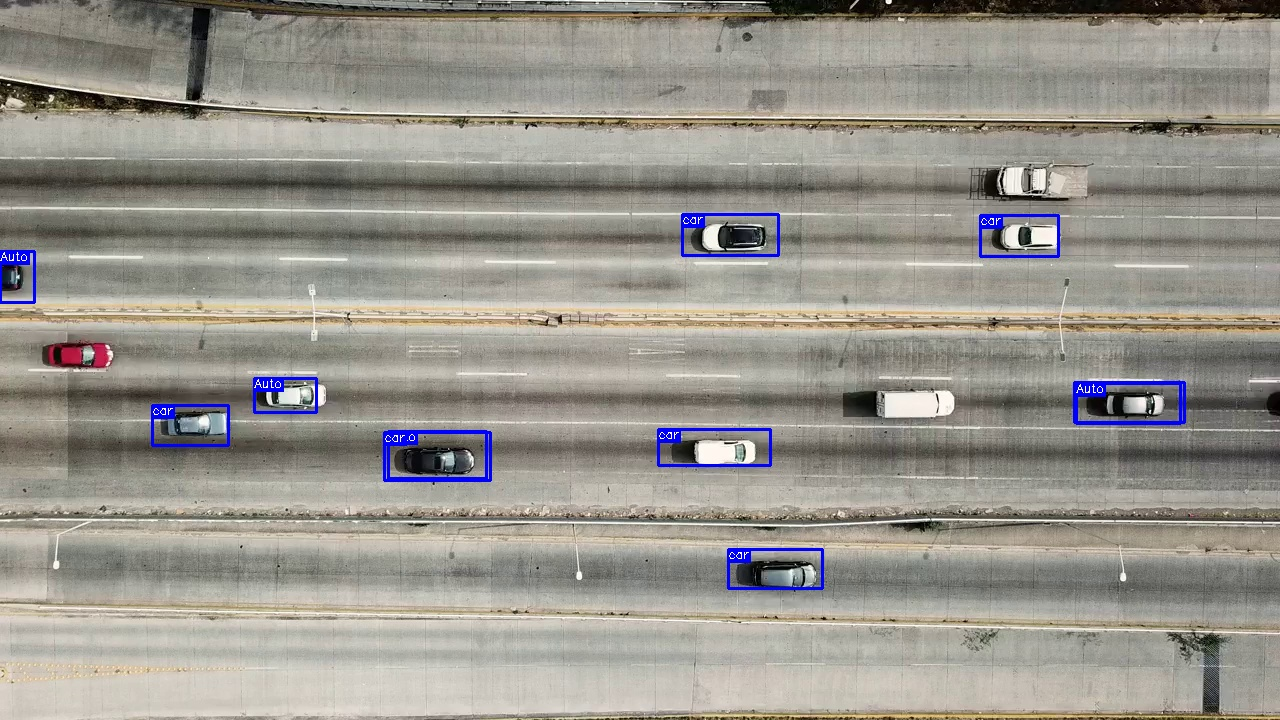

In [14]:


# Save annotated image
model.predict(image_path, confidence=40, overlap=30).save("predicted.jpg")

# Display in notebook
display(Image("predicted.jpg"))

In [ ]:
# All 726 Frames

In [2]:
import sys
sys.path.append(r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\CountingCarVideo\sort")

In [3]:
# --------------------------------------------
# Setup Roboflow Model + Tracker
# --------------------------------------------
from roboflow import Roboflow
from sort import Sort
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

# Initialize Roboflow
rf = Roboflow(api_key="4kWAyhvHtH8jEDp5r")  
project = rf.workspace("vehicle-detection-qkire").project("vehicle-count")
model = project.version(1).model

# Frame paths
FRAME_DIR = r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\CountingCarVideo\Traffic Count_frames"
frame_files = sorted([os.path.join(FRAME_DIR, f) for f in os.listdir(FRAME_DIR) if f.endswith(".jpg")])

# Tracker
tracker = Sort()

# Init
ltr_ids = set()  # left → right (top half)
rtl_ids = set()  # right → left (bottom half)
ltr_count_over_time = []
rtl_count_over_time = []

# Get frame dimensions
sample_img = cv2.imread(frame_files[0])
H, W = sample_img.shape[:2]
midline = H // 2


Blowfish has been deprecated and will be removed in a future release


loading Roboflow workspace...
loading Roboflow project...


In [4]:
# --------------------------------------------
# Run Detection + Tracking + Direction Counting
# --------------------------------------------

track_history = {}

for frame_path in tqdm(frame_files):
    frame = cv2.imread(frame_path)
    
    # Predict using Roboflow model
    preds = model.predict(frame_path, confidence=40, overlap=30).json()
    
    # Parse predictions into [x1, y1, x2, y2, conf]
    detections = []
    for obj in preds['predictions']:
        x, y, w, h = obj['x'], obj['y'], obj['width'], obj['height']
        conf = obj['confidence']
        x1 = x - w/2
        y1 = y - h/2
        x2 = x + w/2
        y2 = y + h/2
        detections.append([x1, y1, x2, y2, conf])

    detections_np = np.array(detections)
    if len(detections_np) == 0:
        detections_np = np.empty((0, 5))

    # Track with SORT
    tracked_objects = tracker.update(detections_np)

    for obj in tracked_objects:
        x1, y1, x2, y2, obj_id = obj.astype(int)
        cx = (x1 + x2) // 2
        cy = (y1 + y2) // 2

        if obj_id not in track_history:
            track_history[obj_id] = []
        track_history[obj_id].append(cx)

        if len(track_history[obj_id]) >= 2:
            if cy < midline:
                ltr_ids.add(obj_id)
            else:
                rtl_ids.add(obj_id)

    ltr_count_over_time.append(len(ltr_ids))
    rtl_count_over_time.append(len(rtl_ids))


100%|████████████████████████████████████████████████████████████████████████████████| 726/726 [06:52<00:00,  1.76it/s]


In [6]:
# --------------------------------------------
# Normalize over Time & Plot
# --------------------------------------------

# Estimated video duration in seconds
T = 24  
time_arr = np.linspace(0, T, len(frame_files))

print("Final count:")
print("➡ Left to Right:", len(ltr_ids))
print("⬅ Right to Left:", len(rtl_ids))

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_arr, ltr_count_over_time, label="Left ➡ Right", linewidth=2)
plt.plot(time_arr, rtl_count_over_time, label="Right ⬅ Left", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Vehicle Count")
plt.title("Vehicle Count Per Direction Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Final count:
➡ Left to Right: 178
⬅ Right to Left: 105


In [ ]:
import cv2
from sort import Sort
from roboflow import Roboflow
from tqdm import tqdm
import os

# Initialize Roboflow
rf = Roboflow(api_key="4kWAyhvHtH8m4bjEDp5r")
project = rf.workspace("vehicle-detection-qkire").project("vehicle-count")
model = project.version(1).model

# Frame input folder
FRAME_DIR = r"C:\Users\algba\NikiTechSolutions\CVAI-HW3\CountingCarVideo\Traffic Count_frames"
frame_files = sorted([os.path.join(FRAME_DIR, f) for f in os.listdir(FRAME_DIR) if f.endswith(".jpg")])

# Tracker
tracker = Sort()

# Video writer setup
first_frame = cv2.imread(frame_files[0])
H, W = first_frame.shape[:2]
fps = 30 
output_path = "vehicle_tracking_output.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video_writer = cv2.VideoWriter(output_path, fourcc, fps, (W, H))

# Midline for direction separation
midline = H // 2
id_directions = {}

for frame_path in tqdm(frame_files, desc="Rendering video"):
    frame = cv2.imread(frame_path)

    # Roboflow detection
    preds = model.predict(frame_path, confidence=40, overlap=30).json()

    detections = []
    for obj in preds['predictions']:
        x, y, w, h = obj['x'], obj['y'], obj['width'], obj['height']
        conf = obj['confidence']
        x1 = x - w/2
        y1 = y - h/2
        x2 = x + w/2
        y2 = y + h/2
        detections.append([x1, y1, x2, y2, conf])
    
    detections_np = np.array(detections)
    if len(detections_np) == 0:
        detections_np = np.empty((0, 5))
    
    tracked_objects = tracker.update(detections_np)

    # Draw all tracked objects
    for obj in tracked_objects:
        x1, y1, x2, y2, obj_id = obj.astype(int)
        cx = (x1 + x2) // 2
        cy = (y1 + y2) // 2

        # Determine direction
        if obj_id not in id_directions:
            id_directions[obj_id] = "→" if cy < midline else "←"
        direction = id_directions[obj_id]

        # Draw box and ID
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
        label = f"ID {obj_id} {direction}"
        cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Write frame to video
    video_writer.write(frame)

video_writer.release()
print(f" Video saved as: {output_path}")


In [8]:
import os
print(os.path.abspath("vehicle_tracking_output.mp4"))

C:\Users\algba\vehicle_tracking_output.mp4


In [ ]:
# import pandas as pd
# df = pd.DataFrame({
#     "Time (s)": time_arr,
#     "Left ➡ Right": ltr_count_over_time,
#     "Right ⬅ Left": rtl_count_over_time
# })
# df.to_csv("vehicle_count_over_time.csv", index=False)